<a href="https://colab.research.google.com/github/amenisahmim/-twitter-sentiment-analysis-bigdata/blob/main/twitter_sentiment_analysis_spark_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PARTIE 1 : Chargement et exploration des données massives

In [ ]:
# Installation des dépendances
!pip install pyspark scikit-learn -q
from pyspark.sql import SparkSession
import pandas as pd
from sklearn.datasets import fetch_california_housing
import time
# Configuration Spark pour le traitement distribué
spark = SparkSession.builder \
.appName("Analyse des sentiments sur Twitter") \
.config("spark.sql.adaptive.enabled", "true") \
.config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
.getOrCreate()
print("Environnement Spark configuré pour le traitement distribué")

Environnement Spark configuré pour le traitement distribué


In [ ]:
# Lire les 5 premières lignes du fichier pour inspection
with open("/content/twitter_training.csv", "r", encoding="latin-1") as f:
    for _ in range(5):
        print(f.readline())


2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"

2401,Borderlands,Positive,"I am coming to the borders and I will kill you all,"

2401,Borderlands,Positive,"im getting on borderlands and i will kill you all,"

2401,Borderlands,Positive,"im coming on borderlands and i will murder you all,"

2401,Borderlands,Positive,"im getting on borderlands 2 and i will murder you me all,"



In [ ]:
df_pandas = pd.read_csv('/content/twitter_training.csv', encoding='latin-1', header=None, names=['id', 'game', 'sentiment', 'text'])
print(df_pandas.info())
df_pandas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   game       74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None


,id,game,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


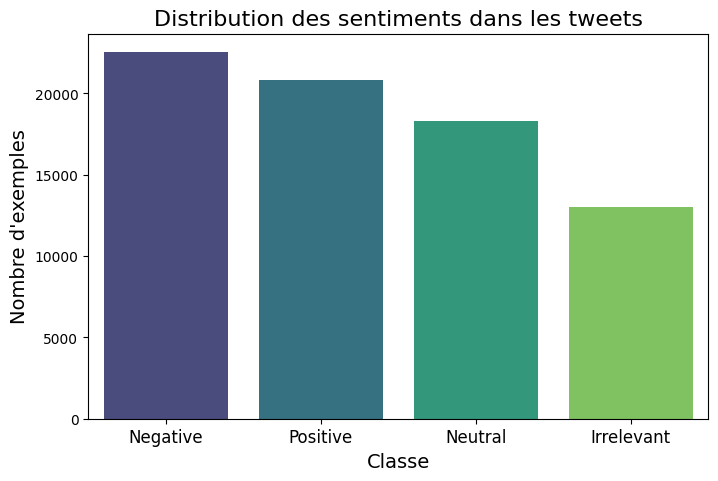

In [ ]:
# Import des librairies
import matplotlib.pyplot as plt
import seaborn as sns

# Utiliser le DataFrame pandas directement
data_pd = df_pandas

# Compter le nombre d'exemples par sentiment
label_counts = data_pd['sentiment'].value_counts()

# Création du graphique
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette="viridis", legend=False)
plt.xlabel("Classe", fontsize=14)
plt.ylabel("Nombre d'exemples", fontsize=14)
plt.title("Distribution des sentiments dans les tweets", fontsize=16)
plt.xticks(fontsize=12)
plt.show()

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Twitter_Sentiment_Analysis").getOrCreate()

# Charger le CSV via Pandas
df_pandas = pd.read_csv(
    "/content/twitter_training.csv",
    header=None,
    names=["id", "topic", "sentiment", "text"]
)

# Convertir en DataFrame Spark
df = spark.createDataFrame(df_pandas)
df = df.repartition(8)  # simuler Big Data
print(f"Nombre de partitions : {df.rdd.getNumPartitions()}")
print(f"Nombre total de tweets : {df.count():,}")
df.printSchema()
df.show(10, truncate=False)


Nombre de partitions : 8
Nombre total de tweets : 74,682
root
 |-- id: long (nullable = true)
 |-- topic: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- text: string (nullable = true)

+-----+-----------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id   |topic            |sentiment |text                                                                                                                                                                                                                                            |
+-----+-----------------+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
print("=== EXPLORATION DU DATASET TWITTER ===")

#  Schéma du dataset
print("\nSchéma de la structure distribuée :")
df.printSchema()

# Échantillon des données
print("\nÉchantillon des tweets :")
df.show(10, truncate=False)

#  Statistiques descriptives pour les colonnes texte et id
print("\nStatistiques descriptives :")
df.select("id").describe().show()
df.selectExpr("length(text) as text_length").describe().show()

# Analyse de la distribution des sentiments
print("\nDistribution des sentiments :")
df.groupBy("sentiment").count().orderBy("count", ascending=False).show()

#  Analyse de la distribution des topics
print("\nDistribution des topics :")
df.groupBy("topic").count().orderBy("count", ascending=False).show()

#  longueur des tweets par sentiment
from pyspark.sql.functions import length
df = df.withColumn("text_length", length("text"))
print("\nLongueur moyenne des tweets par sentiment :")
df.groupBy("sentiment").avg("text_length").show()


=== EXPLORATION DU DATASET TWITTER ===

Schéma de la structure distribuée :
root
 |-- id: long (nullable = true)
 |-- topic: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- text: string (nullable = true)


Échantillon des tweets :
+-----+-----------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id   |topic            |sentiment |text                                                                                                                                                                                                                                            |
+-----+-----------------+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipython-input-958239346.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="sentiment", y="text_length", data=df_length_pd, palette="viridis")


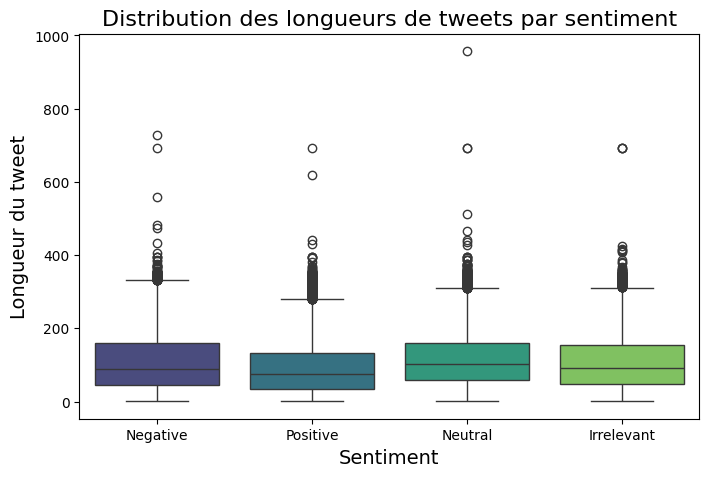

In [ ]:
from pyspark.sql.functions import length, col

# Ajouter une colonne longueur
df_length = df.withColumn("text_length", length(col("text")))

# Convertir en Pandas pour la visualisation
df_length_pd = df_length.select("sentiment", "text_length").toPandas()

plt.figure(figsize=(8,5))
sns.boxplot(x="sentiment", y="text_length", data=df_length_pd, palette="viridis")
plt.title("Distribution des longueurs de tweets par sentiment", fontsize=16)
plt.xlabel("Sentiment", fontsize=14)
plt.ylabel("Longueur du tweet", fontsize=14)
plt.show()


In [ ]:
from pyspark.sql.functions import length

#  Sélection des caractéristiques principales pour Twitter
df_caracteristiques = df.select(
    "sentiment",   # le label du tweet
    "topic",       # le sujet du tweet
    "text"         # le texte complet
    # "cleaned"      # texte nettoyé - this column does not exist yet
)

print("Caractéristiques principales des tweets :")
df_caracteristiques.show(10, truncate=False)

#  Filtrage distribué : par exemple tweets positifs
df_positifs = df.filter(df["sentiment"] == "Positive")
print(f"Nombre de tweets positifs : {df_positifs.count():,}")
df_positifs.show(10, truncate=False)

#  Filtrage optionnel : tweets longs (> 140 caractères)
df_tweets_longs = df.filter(length(df["text"]) > 140)
print(f"Nombre de tweets longs (> 140 caractères) : {df_tweets_longs.count():,}")
df_tweets_longs.show(10, truncate=False)


Caractéristiques principales des tweets :
+----------+-----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sentiment |topic            |text                                                                                                                                                                                                                                                                                         |
+----------+-----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Negati

In [ ]:
from pyspark.sql.functions import col, length, size, split, lit, round

# Ajout de métriques calculées pour les tweets
df_transform = df.withColumn(
    "text_length", length(col("text"))
).withColumn(
    "words_count", size(split(col("text"), " "))
).withColumn(
    "source", lit("Base_Twitter_2025")
)

print("DataFrame enrichi avec métriques calculées :")
df_transform.select(
    "sentiment", "topic", "text", "text_length", "words_count"
).show(10)


DataFrame enrichi avec métriques calculées :
+----------+-----------------+--------------------+-----------+-----------+
| sentiment|            topic|                text|text_length|words_count|
+----------+-----------------+--------------------+-----------+-----------+
|  Negative|PlayStation5(PS5)|The OMG! Ps5 can'...|        111|         17|
|Irrelevant|         Fortnite|10 million olds t...|        285|         47|
|  Positive|      ApexLegends|                 WOW|          3|          1|
|  Positive|            CS-GO|if you've really ...|        129|         24|
|   Neutral|        Microsoft|[.  NEWS] Game de...|        106|         17|
|   Neutral|    Xbox(Xseries)|The LATEST on Kic...|        251|         36|
|   Neutral|            Dota2|Virtus. Pro kept ...|        196|         40|
|   Neutral|         Fortnite|So wait, why were...|        189|         35|
|  Negative|     WorldOfCraft|.. @ Warcraft _ E...|        243|         49|
|  Negative|    Xbox(Xseries)|With the prel

In [ ]:
from pyspark.sql.functions import col, lower, regexp_replace

# On garde uniquement les tweets avec texte non vide
df_clean = df.filter(col("text").isNotNull())

# Nettoyage du texte : minuscules, suppression URL, mentions, caractères spéciaux
df_clean = df_clean.withColumn("text_clean", lower(col("text"))) \
                   .withColumn("text_clean", regexp_replace(col("text_clean"), r"https?://\S+|www\.\S+", "")) \
                   .withColumn("text_clean", regexp_replace(col("text_clean"), r"@\w+", "")) \
                   .withColumn("text_clean", regexp_replace(col("text_clean"), r"[^a-zA-Z\s]", ""))
df_clean.show(5, truncate=False)

+-----+-----------------+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id   |topic            |sentiment|text                                                                                                                                                                                                                                            |text_length|text_clean                                                                                                                                                                                         

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Téléchargement ressources NLTK une seule fois
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

stop_words = set(stopwords.words("english"))

# Stopwords Twitter supplémentaires
twitter_stop = {
    "rt", "via", "lol", "omg", "u", "ur", "im", "dont", "didnt",
    "ill", "id", "ive", "ya", "yo", "pls", "plz"
}

stop_words = stop_words.union(twitter_stop)

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # 1) Lowercase
    text = text.lower()

    # 2) Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # 3) Remove mentions & hashtags
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)

    # 4) Remove emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoji emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags
        "]+" , flags=re.UNICODE
    )
    text = emoji_pattern.sub(r"", text)

    # 5) Remove numbers & punctuation
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))

    # 6) Remove repeated letters: soooo → soo
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)

    # 7) Tokenisation
    tokens = text.split()

    # 8) Remove stopwords
    tokens = [w for w in tokens if w not in stop_words]

    # 9) Lemmatization
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    # 10) Join cleaned text
    text_clean = " ".join(tokens)

    return text_clean


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Enregistrer la fonction Python comme UDF Spark
clean_text_udf = udf(clean_text, StringType())

# Appliquer l'UDF à la colonne 'text'
df = df.withColumn("cleaned", clean_text_udf(df["text"]))
df.show(5, truncate=False)

+-----+-----------------+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+-------------------------------------------------------------------------------------------------------------------------------------+
|id   |topic            |sentiment|text                                                                                                                                                                                                                                            |text_length|cleaned                                                                                                                              |
+-----+-----------------+---------+-----------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer

# Tokenisation
tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")
df_words = tokenizer.transform(df_clean)

# Suppression des stopwords
remover = StopWordsRemover(inputCol="words", outputCol="words_clean")
df_words = remover.transform(df_words)

# Vectorisation (CountVectorizer)
cv = CountVectorizer(inputCol="words_clean", outputCol="features")
cv_model = cv.fit(df_words)
df_features = cv_model.transform(df_words)


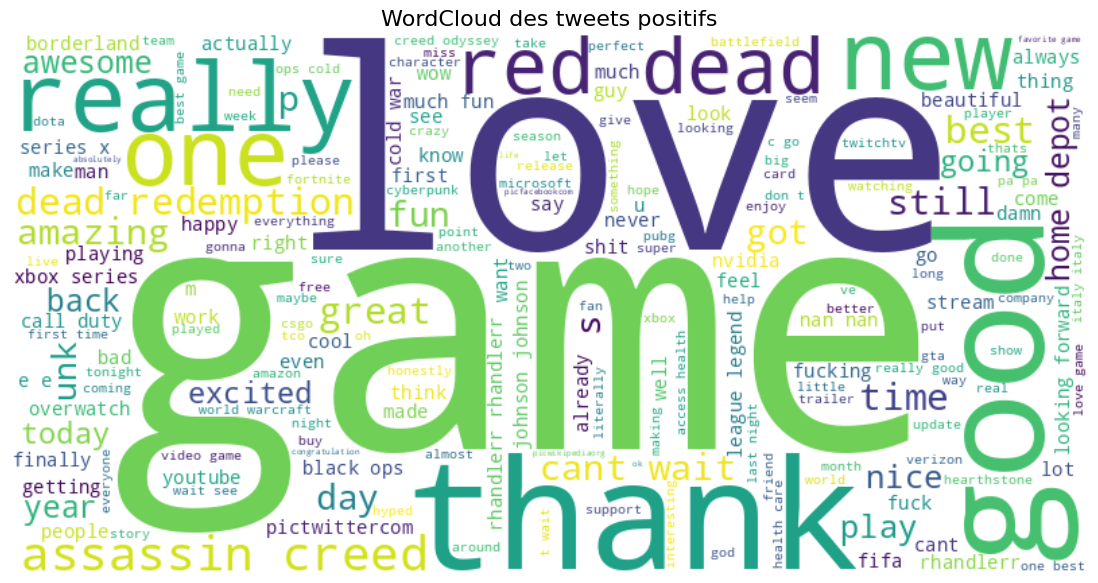

In [ ]:
from wordcloud import WordCloud

# Exemple pour les tweets positifs
positif_text = " ".join(df.filter(df.sentiment=="Positive").select("cleaned").rdd.flatMap(lambda x: x).collect())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positif_text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud des tweets positifs", fontsize=16)
plt.show()


In [ ]:
from collections import Counter
all_words = df.select("cleaned").rdd.flatMap(lambda x: x[0].split()).collect()
counter = Counter(all_words)
print(counter.most_common(20))

[('game', 10346), ('like', 4959), ('get', 4368), ('one', 3713), ('play', 3613), ('good', 3568), ('time', 3492), ('love', 3320), ('really', 3260), ('new', 3209), ('people', 2915), ('johnson', 2874), ('shit', 2802), ('see', 2790), ('best', 2496), ('still', 2451), ('’', 2436), ('player', 2386), ('year', 2331), ('day', 2314)]


In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Convertir le DataFrame Spark 'df' en un DataFrame Pandas pour l'encodage
data = df.toPandas()

le = LabelEncoder()
data['label'] = le.fit_transform(data['sentiment'])
data[['sentiment','label']].head()

,sentiment,label
0,Positive,3
1,Positive,3
2,Positive,3
3,Neutral,2
4,Neutral,2


In [ ]:
# Création de la vue SQL pour Spark
df_transform.createOrReplaceTempView("twitter_data")
print("Vue SQL 'twitter_data' créée pour analyse distribuée")

# Exemple d'analyse par sentiment : nombre de tweets et longueur moyenne
requete_analyse = """
SELECT
    sentiment,
    COUNT(*) AS Nombre_Tweets,
    ROUND(AVG(text_length), 1) AS Longueur_Moyenne,
    ROUND(MIN(text_length), 1) AS Longueur_Min,
    ROUND(MAX(text_length), 1) AS Longueur_Max
FROM twitter_data
GROUP BY sentiment
ORDER BY Nombre_Tweets DESC
"""

resultats_sentiment = spark.sql(requete_analyse)
print("Analyse par sentiment :")
resultats_sentiment.show()


Vue SQL 'twitter_data' créée pour analyse distribuée
Analyse par sentiment :
+----------+-------------+----------------+------------+------------+
| sentiment|Nombre_Tweets|Longueur_Moyenne|Longueur_Min|Longueur_Max|
+----------+-------------+----------------+------------+------------+
|  Negative|        22542|           110.4|           1|         727|
|  Positive|        20832|            95.1|           1|         692|
|   Neutral|        18318|           117.5|           1|         957|
|Irrelevant|        12990|           110.0|           1|         692|
+----------+-------------+----------------+------------+------------+



In [ ]:
# Chemins pour enregistrer les données Twitter
path_json = "/content/twitter_data_json"
path_parquet = "/content/twitter_data_parquet"

# Sauvegarde
df.write.mode("overwrite").json(path_json)
df.write.mode("overwrite").parquet(path_parquet)
print(f"DataFrame Twitter enregistré en JSON à : {path_json}")
print(f"DataFrame Twitter enregistré en Parquet à : {path_parquet}")

# Comparaison des performances
import time

# Lecture JSON
debut = time.time()
spark.read.json(path_json).count()
temps_json = time.time() - debut

# Lecture Parquet
debut = time.time()
spark.read.parquet(path_parquet).count()
temps_parquet = time.time() - debut

print("Temps lecture JSON :", temps_json)
print("Temps lecture Parquet :", temps_parquet)
print("Gain Parquet vs JSON :", temps_json / temps_parquet)


DataFrame Twitter enregistré en JSON à : /content/twitter_data_json
DataFrame Twitter enregistré en Parquet à : /content/twitter_data_parquet
Temps lecture JSON : 3.6709401607513428
Temps lecture Parquet : 0.6565995216369629
Gain Parquet vs JSON : 5.590835874505896


In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, CountVectorizer, IDF, Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

#  Transformation du label 'sentiment' en numérique
indexer = StringIndexer(inputCol="sentiment", outputCol="label")  # label = sentiment numérique

#  Transformation du texte en features numériques
# Tokenisation du texte nettoyé
tokenizer = Tokenizer(inputCol="cleaned", outputCol="words")

# Suppression des stopwords
# Note: Utiliser les stopwords par défaut de StopWordsRemover ou définir une liste personnalisée si nécessaire
remover = StopWordsRemover(inputCol="words", outputCol="words_filtered")

#  Bag-of-Words avec CountVectorizer et IDF
vectorizer = CountVectorizer(inputCol="words_filtered", outputCol="rawFeatures", vocabSize=5000, minDF=5)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Pipeline pour assembler transformations
pipeline = Pipeline(stages=[indexer, tokenizer, remover, vectorizer, idf])
df_ml = pipeline.fit(df).transform(df)

# Affichage pour vérification
print("Features préparées pour l'apprentissage distribué :")
df_ml.select("cleaned", "label", "features").show(5, truncate=False)

#  Division des données en train / test
train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=42)
print(f"Données train : {train_data.count():,}, données test : {test_data.count():,}")

Features préparées pour l'apprentissage distribué :
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|cleaned                                                                                                                        

In [ ]:
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF

#  Nettoyage de texte
# - Minuscules
# - Suppression des URLs, mentions et caractères spéciaux
df_clean = df.withColumn("text_clean", lower(col("text")))
df_clean = df_clean.withColumn("text_clean", regexp_replace(col("text_clean"), r"http\S+", ""))  # URLs
df_clean = df_clean.withColumn("text_clean", regexp_replace(col("text_clean"), r"@\w+", ""))     # Mentions
df_clean = df_clean.withColumn("text_clean", regexp_replace(col("text_clean"), r"[^a-zA-Z\s]", ""))  # Caractères spéciaux

#  Tokenisation
tokenizer = RegexTokenizer(inputCol="text_clean", outputCol="tokens", pattern="\\s+")
df_tokens = tokenizer.transform(df_clean)

#  Suppression des stopwords
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
df_filtered = remover.transform(df_tokens)

#  Vectorisation CountVectorizer
cv = CountVectorizer(inputCol="filtered_tokens", outputCol="raw_features", vocabSize=5000, minDF=2)
cv_model = cv.fit(df_filtered)
df_cv = cv_model.transform(df_filtered)

#  TF-IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(df_cv)
df_ready = idf_model.transform(df_cv)

# Vérification
df_ready.select("text", "text_clean", "filtered_tokens", "features").show(5, truncate=False)


+------------------------------------------------------------------+---------------------------------------------------------+------------------------------------------+--------------------------------------------------------------------------------------------------------------------------+
|text                                                              |text_clean                                               |filtered_tokens                           |features                                                                                                                  |
+------------------------------------------------------------------+---------------------------------------------------------+------------------------------------------+--------------------------------------------------------------------------------------------------------------------------+
|Shoutout to those we just found out the price of SSD's            |shoutout to those we just found out the price of ssds

In [ ]:
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

print("=== ENTRAÎNEMENT DES MODÈLES DE CLASSIFICATION DISTRIBUÉS ===")

# Régression logistique (classification multi-classes)
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Arbre de décision
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=10)
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50, maxDepth=10, seed=42)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

print("Modèles entraînés avec succès")

# Évaluation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

print("Accuracy Régression Logistique :", evaluator.evaluate(lr_predictions))
print("Accuracy Arbre de Décision   :", evaluator.evaluate(dt_predictions))
print("Accuracy Random Forest       :", evaluator.evaluate(rf_predictions))


=== ENTRAÎNEMENT DES MODÈLES DE CLASSIFICATION DISTRIBUÉS ===
Modèles entraînés avec succès
Accuracy Régression Logistique : 0.6921190654587562
Accuracy Arbre de Décision   : 0.37415707376881685
Accuracy Random Forest       : 0.4540562631973299


In [ ]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

#  Préparation des données : train/test split
# 'df_ml' already has 'label' and 'features' columns from previous pipeline
train_data_nb, test_data_nb = df_ml.randomSplit([0.8, 0.2], seed=42)

#  Définition du modèle Naive Bayes
# Use 'label' column which is numeric
nb = NaiveBayes(featuresCol="features", labelCol="label", smoothing=1.0, modelType="multinomial")

#  Pipeline
pipeline_nb = Pipeline(stages=[nb])

#  Entraînement du modèle
model_nb = pipeline_nb.fit(train_data_nb)

#  Prédictions
predictions_nb = model_nb.transform(test_data_nb)

#  Évaluation
evaluator_nb = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)
accuracy_nb = evaluator_nb.evaluate(predictions_nb)
print(f"Accuracy du modèle Naive Bayes : {accuracy_nb:.4f}")

#  Voir un échantillon de prédictions
predictions_nb.select("text", "sentiment", "label", "prediction").show(10, truncate=False)


Accuracy du modèle Naive Bayes : 0.6230
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----+----------+
|text                                                                                                                                                                                                                                                                                   |sentiment |label|prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----+----------+
|Admit it subs, you leak over 

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Configuration de l'évaluateur pour classification
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)

# Modèles et prédictions
models = {
    "Logistic Regression": lr_predictions,
    "Decision Tree": dt_predictions,
    "Random Forest": rf_predictions
}

print("=== COMPARAISON DES PERFORMANCES DE CLASSIFICATION ===")
print("Modèle                 | Accuracy | F1 Score")
print("-" * 45)

for name, predictions in models.items():
    acc = evaluator_acc.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)
    print(f"{name:22} | {acc:8.4f} | {f1:8.4f}")

# Exemple de prédictions vs valeurs réelles
print("\nExemple de prédictions vs valeurs réelles :")
rf_predictions.select("sentiment", "prediction").show(10)


=== COMPARAISON DES PERFORMANCES DE CLASSIFICATION ===
Modèle                 | Accuracy | F1 Score
---------------------------------------------
Logistic Regression    |   0.6921 |   0.6909
Decision Tree          |   0.3742 |   0.2946
Random Forest          |   0.4541 |   0.3775

Exemple de prédictions vs valeurs réelles :
+----------+----------+
| sentiment|prediction|
+----------+----------+
|   Neutral|       1.0|
|  Negative|       0.0|
|  Positive|       0.0|
|  Positive|       2.0|
|  Positive|       1.0|
|   Neutral|       1.0|
|   Neutral|       0.0|
|  Negative|       0.0|
|   Neutral|       2.0|
|Irrelevant|       0.0|
+----------+----------+
only showing top 10 rows


In [ ]:
# 🔹 IMPORTS
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 🔹 CRÉATION DE SPARK SESSION
spark = SparkSession.builder \
    .appName("Twitter_Sentiment_Analysis") \
    .getOrCreate()

print("SparkSession créée ✅")

# 🔹 ÉTAPE 1 : INDEXATION DES LABELS
# Transformer la colonne sentiment (texte) en label numérique
indexer = StringIndexer(inputCol="sentiment", outputCol="label")
df_ml = indexer.fit(df).transform(df)

# 🔹 ÉTAPE 2 : PIPELINE NLP
# Tokenisation
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

# Suppression des stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# CountVectorizer
cv = CountVectorizer(inputCol="filtered_words", outputCol="raw_features", vocabSize=5000, minDF=2)

# TF-IDF
idf = IDF(inputCol="raw_features", outputCol="features")

# Modèle Naive Bayes
nb = NaiveBayes(featuresCol="features", labelCol="label", smoothing=1.0, modelType="multinomial")

# 🔹 ÉTAPE 3 : PIPELINE COMPLET
pipeline = Pipeline(stages=[tokenizer, remover, cv, idf, nb])

# 🔹 ÉTAPE 4 : TRAIN/TEST SPLIT
train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=42)

# 🔹 ÉTAPE 5 : ENTRAÎNEMENT
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

# 🔹 ÉTAPE 6 : ÉVALUATION
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy du modèle Naive Bayes après NLP : {accuracy:.4f}")

# Optionnel : F1-score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluator_f1.evaluate(predictions)
print(f"F1-score : {f1:.4f}")

# 🔹 ÉTAPE 7 : VISUALISER QUELQUES PRÉDICTIONS
predictions.select("text", "sentiment", "label", "prediction").show(10, truncate=False)


SparkSession créée ✅
Accuracy du modèle Naive Bayes après NLP : 0.6376
F1-score : 0.6357
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----+----------+
|text                                                                                                                                                                                                                                                                                   |sentiment |label|prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Convert Spark DataFrame to Pandas for scikit-learn compatibility
pandas_df_ml = df_ml.select("cleaned", "label", "sentiment").toPandas()

X = pandas_df_ml['cleaned']
y = pandas_df_ml['label']

# Create and fit a LabelEncoder to get the class names for the report
# This 'le_for_names' is used only to retrieve the original string labels for target_names
le_for_names = LabelEncoder()
le_for_names.fit(pandas_df_ml['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(
    max_features=10000,   # nombre max de mots
    ngram_range=(1,2)     # unigrams + bigrams
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model = LogisticRegression(max_iter=500)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print("=== Évaluation du modèle ===")
print("Accuracy  :", accuracy_score(y_test, y_pred)*100, "%")
print(classification_report(y_test, y_pred, target_names=le_for_names.classes_))

=== Évaluation du modèle ===
Accuracy  : 71.48691169578898 %
              precision    recall  f1-score   support

  Irrelevant       0.74      0.80      0.77      4509
    Negative       0.73      0.74      0.73      4166
     Neutral       0.66      0.69      0.68      3664
    Positive       0.73      0.56      0.63      2598

    accuracy                           0.71     14937
   macro avg       0.71      0.70      0.70     14937
weighted avg       0.72      0.71      0.71     14937



In [ ]:
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#  Nettoyage des tweets
def clean_text(text):
    text = text.lower()                             # minuscules
    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # URLs
    text = re.sub(r"@\w+", "", text)               # mentions
    text = re.sub(r"[^a-z\s]", "", text)           # ponctuation
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

pandas_df_ml['cleaned'] = pandas_df_ml['cleaned'].apply(clean_text)

#  Split train/test
X = pandas_df_ml['cleaned']
y = pandas_df_ml['label']

le_for_names = LabelEncoder()
le_for_names.fit(pandas_df_ml['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#  TF-IDF vectorizer amélioré
tfidf = TfidfVectorizer(
    max_features=20000,   # plus de mots
    ngram_range=(1,3),    # unigrams + bigrams + trigrams
    min_df=5              # ignorer mots très rares
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#  Modèle Logistic Regression avec class_weight
model = LogisticRegression(max_iter=1000, class_weight="balanced", C=2.0)
model.fit(X_train_tfidf, y_train)

#  Prédictions et évaluation
y_pred = model.predict(X_test_tfidf)
print("=== Évaluation du modèle amélioré ===")
print("Accuracy  :", accuracy_score(y_test, y_pred)*100, "%")
print(classification_report(y_test, y_pred, target_names=le_for_names.classes_))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=== Évaluation du modèle amélioré ===
Accuracy  : 78.02102162415478 %
              precision    recall  f1-score   support

  Irrelevant       0.84      0.80      0.82      4509
    Negative       0.81      0.77      0.79      4166
     Neutral       0.72      0.78      0.75      3664
    Positive       0.73      0.76      0.75      2598

    accuracy                           0.78     14937
   macro avg       0.78      0.78      0.78     14937
weighted avg       0.78      0.78      0.78     14937



=== SIMULATION DE FLUX DE TWEETS AVEC LOGISTICREGRESSION ===

--- Batch 1 ---
    id              topic                                             text  \
0    0              CS-GO               CS-GO seems okay, nothing special.   
1    1  PlayStation5(PS5)   PlayStation5(PS5) seems okay, nothing special.   
2    2             Google                     I love playing Google today!   
3    3        Borderlands                I love playing Borderlands today!   
4    4  PlayStation5(PS5)   PlayStation5(PS5) seems okay, nothing special.   
5    5       WorldOfCraft     WorldOfCraft is terrible, I am disappointed.   
6    6             Google                     I love playing Google today!   
7    7          Overwatch        Overwatch is terrible, I am disappointed.   
8    8          Overwatch                  I love playing Overwatch today!   
9    9    LeagueOfLegends  LeagueOfLegends is terrible, I am disappointed.   
10  10       WorldOfCraft        WorldOfCraft seems okay, nothin

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


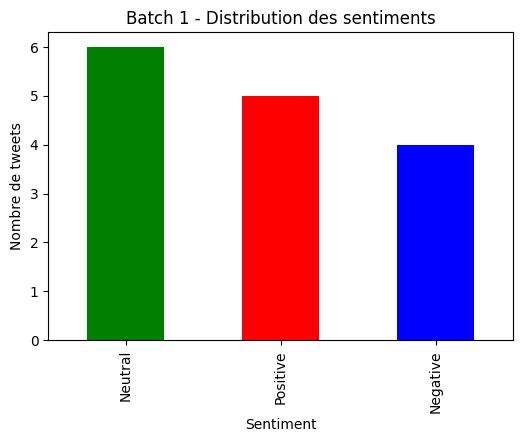


--- Batch 2 ---
    id              topic                                               text  \
0    0       WorldOfCraft                   Just talking about WorldOfCraft.   
1    1          Overwatch             Overwatch seems okay, nothing special.   
2    2  PlayStation5(PS5)  PlayStation5(PS5) is terrible, I am disappointed.   
3    3              CS-GO              CS-GO is terrible, I am disappointed.   
4    4             Google                Google seems okay, nothing special.   
5    5              CS-GO                        I love playing CS-GO today!   
6    6              CS-GO                          Just talking about CS-GO.   
7    7              CS-GO                        I love playing CS-GO today!   
8    8             Google                       I love playing Google today!   
9    9              CS-GO                        I love playing CS-GO today!   
10  10       WorldOfCraft                 I love playing WorldOfCraft today!   
11  11             Amaz

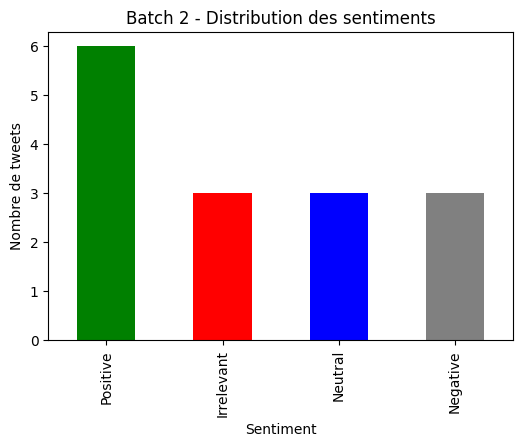


--- Batch 3 ---
    id              topic                                            text  \
0    0  PlayStation5(PS5)  PlayStation5(PS5) seems okay, nothing special.   
1    1             Google          Google is terrible, I am disappointed.   
2    2             Google                    I love playing Google today!   
3    3  PlayStation5(PS5)         I love playing PlayStation5(PS5) today!   
4    4          Overwatch          Overwatch seems okay, nothing special.   
5    5       WorldOfCraft              I love playing WorldOfCraft today!   
6    6              CS-GO           CS-GO is terrible, I am disappointed.   
7    7    LeagueOfLegends           I love playing LeagueOfLegends today!   
8    8          Overwatch          Overwatch seems okay, nothing special.   
9    9          Overwatch          Overwatch seems okay, nothing special.   
10  10        Borderlands               I love playing Borderlands today!   
11  11          Overwatch       Overwatch is terrible, I am

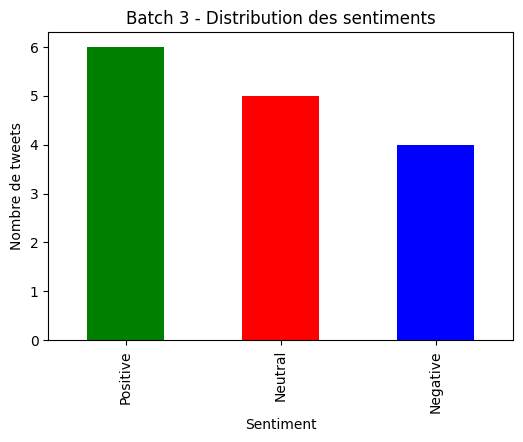


--- Batch 4 ---
    id              topic                                               text  \
0    0  PlayStation5(PS5)            I love playing PlayStation5(PS5) today!   
1    1              CS-GO                 CS-GO seems okay, nothing special.   
2    2             Google             Google is terrible, I am disappointed.   
3    3             Amazon                       I love playing Amazon today!   
4    4              CS-GO              CS-GO is terrible, I am disappointed.   
5    5        Borderlands                    Just talking about Borderlands.   
6    6          Overwatch             Overwatch seems okay, nothing special.   
7    7    LeagueOfLegends       LeagueOfLegends seems okay, nothing special.   
8    8    LeagueOfLegends                Just talking about LeagueOfLegends.   
9    9    LeagueOfLegends       LeagueOfLegends seems okay, nothing special.   
10  10       WorldOfCraft                 I love playing WorldOfCraft today!   
11  11        Borderlan

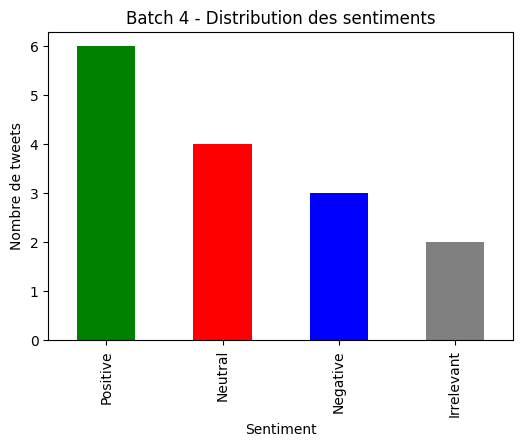


--- Batch 5 ---
    id              topic                                            text  \
0    0       WorldOfCraft    WorldOfCraft is terrible, I am disappointed.   
1    1          Overwatch       Overwatch is terrible, I am disappointed.   
2    2          Overwatch                 I love playing Overwatch today!   
3    3             Google                      Just talking about Google.   
4    4          Overwatch          Overwatch seems okay, nothing special.   
5    5  PlayStation5(PS5)  PlayStation5(PS5) seems okay, nothing special.   
6    6          Overwatch       Overwatch is terrible, I am disappointed.   
7    7             Google                    I love playing Google today!   
8    8             Amazon                    I love playing Amazon today!   
9    9              CS-GO                     I love playing CS-GO today!   
10  10             Amazon                    I love playing Amazon today!   
11  11              CS-GO              CS-GO seems okay, no

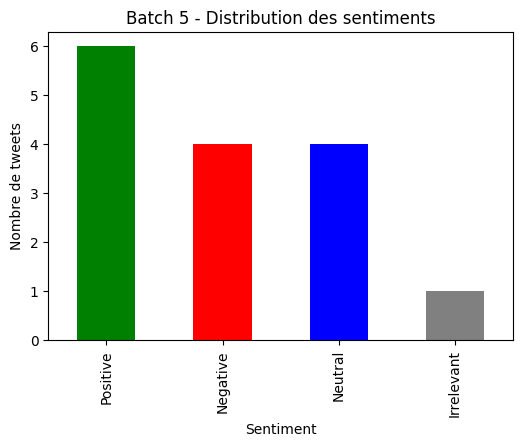


Simulation terminée avec succès !


In [ ]:
import pandas as pd
import numpy as np
import random
import time
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import nltk
import re

nltk.download('stopwords')
from nltk.corpus import stopwords

# Stopwords
stop_words = set(stopwords.words("english"))

#  Fonction de nettoyage
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = " ".join([w for w in text.split() if w not in stop_words])
    return text

#  Simulation de tweets
def simuler_tweets(n_tweets=10):
    topics = ["PlayStation5(PS5)", "LeagueOfLegends", "Overwatch",
              "WorldOfCraft", "CS-GO", "Borderlands", "Google", "Amazon"]
    sentiments = ["Positive", "Negative", "Neutral", "Irrelevant"]

    tweets_data = []
    for i in range(n_tweets):
        sentiment = random.choices(sentiments, weights=[0.4,0.3,0.2,0.1])[0]  # plus de Positif
        topic = random.choice(topics)
        if sentiment == "Positive":
            text = f"I love playing {topic} today!"
        elif sentiment == "Negative":
            text = f"{topic} is terrible, I am disappointed."
        elif sentiment == "Neutral":
            text = f"{topic} seems okay, nothing special."
        else:
            text = f"Just talking about {topic}."
        tweet = {"id": i, "topic": topic, "text": text, "true_sentiment": sentiment}
        tweets_data.append(tweet)
    return pd.DataFrame(tweets_data)

#  Exemple de dataset pour entraîner TF-IDF + Logistic Regression
# (ici on crée un dataset simulé pour que le code soit exécutable)
df_train = pd.concat([simuler_tweets(50) for _ in range(5)], ignore_index=True)
df_train["cleaned"] = df_train["text"].apply(clean_text)

X_train = df_train["cleaned"]
y_train = df_train["true_sentiment"]

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)

model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train_tfidf, y_train_enc)

print("=== SIMULATION DE FLUX DE TWEETS AVEC LOGISTICREGRESSION ===")

#  Simulation en flux
n_batches = 5
batch_size = 15

for batch_num in range(1, n_batches+1):
    print(f"\n--- Batch {batch_num} ---")
    df_batch = simuler_tweets(batch_size)
    df_batch["cleaned"] = df_batch["text"].apply(clean_text)
    X_batch_tfidf = tfidf.transform(df_batch["cleaned"])

    # Prédiction
    y_pred_enc = model.predict(X_batch_tfidf)
    df_batch["prediction"] = le.inverse_transform(y_pred_enc)

    print(df_batch[["id", "topic", "text", "prediction"]])

    # Distribution des sentiments
    counts = df_batch["prediction"].value_counts()
    print("\nDistribution des sentiments :")
    print(counts)

    # Graphique
    plt.figure(figsize=(6,4))
    counts.plot(kind="bar", color=["green","red","blue","gray"])
    plt.title(f"Batch {batch_num} - Distribution des sentiments")
    plt.xlabel("Sentiment")
    plt.ylabel("Nombre de tweets")
    plt.show()

    time.sleep(1)

print("\nSimulation terminée avec succès !")


=== SIMULATION DE FLUX DE TWEETS RÉALISTES AVEC LOGISTICREGRESSION ===

--- Batch 1 ---
    id              topic                                               text  \
0    0  PlayStation5(PS5)  I love playing PlayStation5(PS5) today! 👍 #Pla...   
1    1              CS-GO  I love playing CS-GO today! 👍 #CS-GO @user50 h...   
2    2  PlayStation5(PS5)  PlayStation5(PS5) is terrible 😡 #PlayStation5(...   
3    3        Borderlands  Borderlands is terrible 😡 #Borderlands @user15...   
4    4             Google  I love playing Google today! 😡 #Google @user42...   
5    5  PlayStation5(PS5)  PlayStation5(PS5) seems okay, nothing special....   
6    6              CS-GO  I love playing CS-GO today! 😂 #CS-GO @user15 h...   
7    7          Overwatch  I love playing Overwatch today! 👍 #Overwatch @...   
8    8             Google  Google is terrible 😡 #Google @user3 http://exa...   
9    9    LeagueOfLegends  I love playing LeagueOfLegends today! 👍 #Leagu...   
10  10  PlayStation5(PS5)  PlayS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


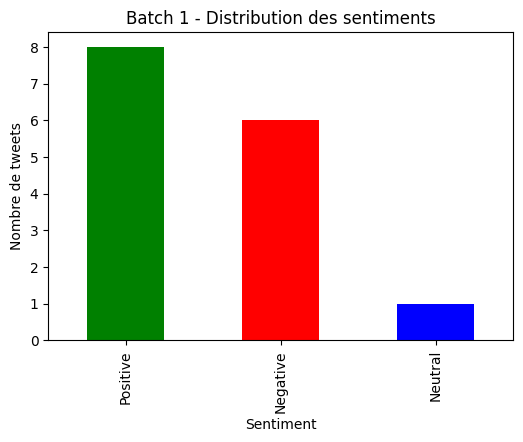


--- Batch 2 ---
    id              topic                                               text  \
0    0             Amazon  Just talking about Amazon @user50 😀 http://exa...   
1    1        Borderlands  Borderlands seems okay, nothing special. 👎 #Bo...   
2    2  PlayStation5(PS5)  I love playing PlayStation5(PS5) today! 👍 #Pla...   
3    3    LeagueOfLegends  LeagueOfLegends is terrible 😡 #LeagueOfLegends...   
4    4    LeagueOfLegends  I love playing LeagueOfLegends today! 👍 #Leagu...   
5    5       WorldOfCraft  I love playing WorldOfCraft today! 👍 #WorldOfC...   
6    6             Amazon  I love playing Amazon today! 👍 #Amazon @user10...   
7    7  PlayStation5(PS5)  I love playing PlayStation5(PS5) today! 👎 #Pla...   
8    8       WorldOfCraft  I love playing WorldOfCraft today! 😂 #WorldOfC...   
9    9  PlayStation5(PS5)  I love playing PlayStation5(PS5) today! 👎 #Pla...   
10  10              CS-GO  I love playing CS-GO today! 😀 #CS-GO @user6 ht...   
11  11    LeagueOfLegen

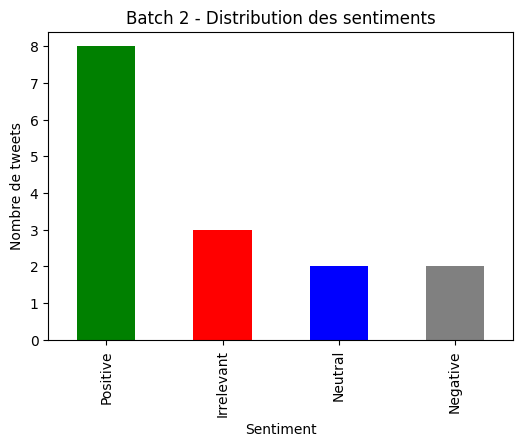


--- Batch 3 ---
    id              topic                                               text  \
0    0    LeagueOfLegends  I love playing LeagueOfLegends today! 👍 #Leagu...   
1    1             Google  Google is terrible 😡 #Google @user36 http://ex...   
2    2        Borderlands  I love playing Borderlands today! 😢 #Borderlan...   
3    3             Google  Google seems okay, nothing special. 👎 #Google ...   
4    4       WorldOfCraft  WorldOfCraft is terrible 😡 #WorldOfCraft @user...   
5    5  PlayStation5(PS5)  I love playing PlayStation5(PS5) today! 😀 #Pla...   
6    6    LeagueOfLegends  I love playing LeagueOfLegends today! 😢 #Leagu...   
7    7  PlayStation5(PS5)  PlayStation5(PS5) is terrible 😡 #PlayStation5(...   
8    8       WorldOfCraft  I love playing WorldOfCraft today! 😢 #WorldOfC...   
9    9              CS-GO  I love playing CS-GO today! 😢 #CS-GO @user35 h...   
10  10        Borderlands  I love playing Borderlands today! 👎 #Borderlan...   
11  11             Amaz

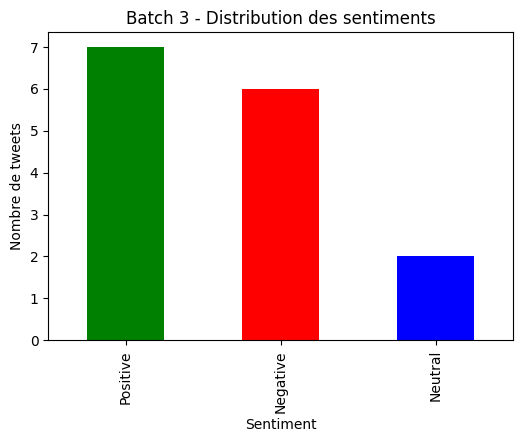


--- Batch 4 ---
    id              topic                                               text  \
0    0              CS-GO  Just talking about CS-GO @user13 👎 http://exam...   
1    1          Overwatch  I love playing Overwatch today! 👎 #Overwatch @...   
2    2       WorldOfCraft  I love playing WorldOfCraft today! 👎 #WorldOfC...   
3    3              CS-GO  CS-GO is terrible 😡 #CS-GO @user36 http://exam...   
4    4       WorldOfCraft  WorldOfCraft seems okay, nothing special. 😡 #W...   
5    5          Overwatch  I love playing Overwatch today! 😀 #Overwatch @...   
6    6        Borderlands  I love playing Borderlands today! 😡 #Borderlan...   
7    7             Google  I love playing Google today! 😡 #Google @user41...   
8    8        Borderlands  I love playing Borderlands today! 👍 #Borderlan...   
9    9       WorldOfCraft  I love playing WorldOfCraft today! 😀 #WorldOfC...   
10  10  PlayStation5(PS5)  I love playing PlayStation5(PS5) today! 👍 #Pla...   
11  11       WorldOfCra

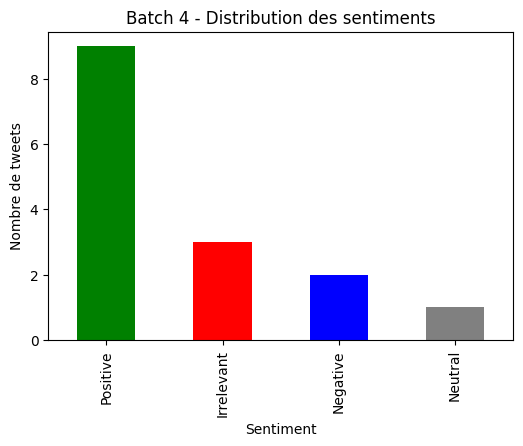


--- Batch 5 ---
    id              topic                                               text  \
0    0             Amazon  I love playing Amazon today! 👎 #Amazon @user8 ...   
1    1             Google  Google is terrible 😡 #Google @user1 http://exa...   
2    2    LeagueOfLegends  LeagueOfLegends is terrible 😡 #LeagueOfLegends...   
3    3          Overwatch  Overwatch is terrible 😡 #Overwatch @user28 htt...   
4    4    LeagueOfLegends  I love playing LeagueOfLegends today! 👍 #Leagu...   
5    5       WorldOfCraft  I love playing WorldOfCraft today! 😡 #WorldOfC...   
6    6          Overwatch  Overwatch is terrible 😡 #Overwatch @user40 htt...   
7    7             Amazon  Amazon is terrible 😡 #Amazon @user40 http://ex...   
8    8             Google  Google is terrible 😡 #Google @user12 http://ex...   
9    9    LeagueOfLegends  LeagueOfLegends is terrible 😡 #LeagueOfLegends...   
10  10       WorldOfCraft  I love playing WorldOfCraft today! 😢 #WorldOfC...   
11  11             Amaz

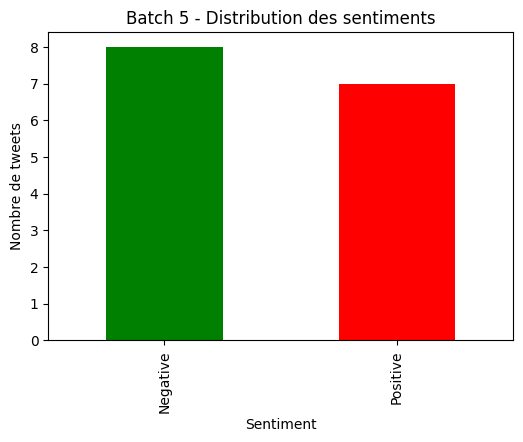


Simulation terminée avec succès !


In [ ]:
import pandas as pd
import numpy as np
import random
import time
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import nltk
import re

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

# 1️⃣ Nettoyage amélioré pour emojis, hashtags, mentions, URLs
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # URLs
    text = re.sub(r"@\w+", "", text)                     # mentions
    text = re.sub(r"#\w+", "", text)                     # hashtags
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F"
                               "\U0001F300-\U0001F5FF"
                               "\U0001F680-\U0001F6FF"
                               "\U0001F1E0-\U0001F1FF]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)                  # emojis
    text = re.sub(r"[^a-z\s]", "", text)
    text = " ".join([w for w in text.split() if w not in stop_words])
    return text

# 2️⃣ Fonction de simulation de tweets réalistes
def simuler_tweets_realistes(n_tweets=10):
    topics = ["PlayStation5(PS5)", "LeagueOfLegends", "Overwatch",
              "WorldOfCraft", "CS-GO", "Borderlands", "Google", "Amazon"]
    sentiments = ["Positive", "Negative", "Neutral", "Irrelevant"]
    emojis = ["😀", "😂", "😢", "😡", "👍", "👎"]

    tweets_data = []
    for i in range(n_tweets):
        sentiment = random.choices(sentiments, weights=[0.4,0.3,0.2,0.1])[0]
        topic = random.choice(topics)
        hashtag = f"#{topic.replace(' ','')}"
        mention = f"@user{random.randint(1,50)}"
        emoji = random.choice(emojis)
        url = f"http://example.com/{random.randint(1,100)}"

        if sentiment == "Positive":
            text = f"I love playing {topic} today! {emoji} {hashtag} {mention} {url}"
        elif sentiment == "Negative":
            text = f"{topic} is terrible 😡 {hashtag} {mention} {url}"
        elif sentiment == "Neutral":
            text = f"{topic} seems okay, nothing special. {emoji} {hashtag} {url}"
        else:
            text = f"Just talking about {topic} {mention} {emoji} {url}"

        tweets_data.append({
            "id": i,
            "topic": topic,
            "text": text,
            "true_sentiment": sentiment
        })

    return pd.DataFrame(tweets_data)

# 3️⃣ Création d'un dataset pour entraîner TF-IDF + Logistic Regression
df_train = pd.concat([simuler_tweets_realistes(50) for _ in range(5)], ignore_index=True)
df_train["cleaned"] = df_train["text"].apply(clean_text)

X_train = df_train["cleaned"]
y_train = df_train["true_sentiment"]

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)

model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train_tfidf, y_train_enc)

print("=== SIMULATION DE FLUX DE TWEETS RÉALISTES AVEC LOGISTICREGRESSION ===")

# 4️⃣ Simulation en flux
n_batches = 5
batch_size = 15

for batch_num in range(1, n_batches+1):
    print(f"\n--- Batch {batch_num} ---")
    df_batch = simuler_tweets_realistes(batch_size)
    df_batch["cleaned"] = df_batch["text"].apply(clean_text)
    X_batch_tfidf = tfidf.transform(df_batch["cleaned"])

    # Prédiction
    y_pred_enc = model.predict(X_batch_tfidf)
    df_batch["prediction"] = le.inverse_transform(y_pred_enc)

    print(df_batch[["id", "topic", "text", "prediction"]])

    # Distribution des sentiments
    counts = df_batch["prediction"].value_counts()
    print("\nDistribution des sentiments :")
    print(counts)

    # Graphique
    plt.figure(figsize=(6,4))
    counts.plot(kind="bar", color=["green","red","blue","gray"])
    plt.title(f"Batch {batch_num} - Distribution des sentiments")
    plt.xlabel("Sentiment")
    plt.ylabel("Nombre de tweets")
    plt.show()

    time.sleep(1)

print("\nSimulation terminée avec succès !")


In [ ]:
import pandas as pd
import time
import random
from datetime import datetime
from collections import Counter
from IPython.display import clear_output

# Simulation de tweets réalistes
topics = ["PlayStation5(PS5)", "LeagueOfLegends", "Overwatch", "WorldOfCraft",
          "CS-GO", "Borderlands", "Google", "Amazon"]

sample_texts = [
    "I love playing {} today! 😀",
    "Just talking about {} 😡",
    "{} seems okay, nothing special. 👍",
    "{} is terrible, I am disappointed. 😢",
    "I just bought {}, excited to try it! 😂"
]

# Modèle de prédiction simulé
def predict_sentiment(text):
    """Simule une prédiction de sentiment à partir du texte"""
    text = text.lower()
    if "love" in text or "excited" in text:
        return "Positive"
    elif "terrible" in text or "disappointed" in text:
        return "Negative"
    elif "okay" in text:
        return "Neutral"
    else:
        return "Irrelevant"

def generate_tweet(id):
    topic = random.choice(topics)
    text = random.choice(sample_texts).format(topic)
    return {"id": id, "topic": topic, "text": text, "timestamp": datetime.now()}

# Simulation de flux continu
tweet_id = 0
sentiment_counter = Counter()

print("=== SIMULATION DE FLUX DE TWEETS EN TEMPS RÉEL ===\n")

try:
    while tweet_id < 50:  # Simule 50 tweets au total
        tweet = generate_tweet(tweet_id)
        tweet['prediction'] = predict_sentiment(tweet['text'])

        # Affichage en temps réel
        clear_output(wait=True)  # Pour actualiser le tableau à chaque tweet
        df_display = pd.DataFrame([tweet])
        print(f"Tweet #{tweet_id + 1}")
        print(df_display[["id", "topic", "text", "prediction"]])

        # Mise à jour du compteur de sentiments
        sentiment_counter[tweet['prediction']] += 1

        # Affichage de la distribution
        print("\nDistribution actuelle des sentiments :")
        for sentiment, count in sentiment_counter.items():
            print(f"{sentiment}: {count}")

        tweet_id += 1
        time.sleep(1)  # Pause de 1 seconde pour simuler le streaming
except KeyboardInterrupt:
    print("\nSimulation interrompue par l'utilisateur.")

print("\nSimulation terminée !")


Tweet #50
   id         topic                                  text prediction
0  49  WorldOfCraft  I love playing WorldOfCraft today! 😀   Positive

Distribution actuelle des sentiments :
Neutral: 5
Positive: 21
Negative: 12
Irrelevant: 12

Simulation terminée !


In [ ]:
all_tweets = []  # liste pour stocker tous les tweets

# À l'intérieur de ta boucle while
all_tweets.append(tweet)

# Après la simulation
df_all = pd.DataFrame(all_tweets)
df_all.to_csv("tweets_predits.csv", index=False)
print("✅ Fichier CSV local créé : tweets_predits.csv")


✅ Fichier CSV local créé : tweets_predits.csv


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("TweetAnalysis").getOrCreate()

# Charger le CSV
df_spark = spark.read.csv("tweets_predits.csv", header=True, inferSchema=True)

df_spark.show()


+---+------------+--------------------+--------------------+----------+
| id|       topic|                text|           timestamp|prediction|
+---+------------+--------------------+--------------------+----------+
| 49|WorldOfCraft|I love playing Wo...|2025-12-19 19:38:...|  Positive|
+---+------------+--------------------+--------------------+----------+



In [ ]:
hdfs_local_path = "/content/hdfs/tweets/tweets_predits"  # chemin simulant HDFS

# Créer le dossier si nécessaire
import os
os.makedirs(hdfs_local_path, exist_ok=True)

# Écriture CSV
df_spark.coalesce(1).write.mode("overwrite").csv(hdfs_local_path, header=True)
print("✅ Fichier stocké dans hdfs/tweets/ (simulation HDFS)")


✅ Fichier stocké dans hdfs/tweets/ (simulation HDFS)


In [ ]:
df_from_local_hdfs = spark.read.csv(hdfs_local_path, header=True, inferSchema=True)
df_from_local_hdfs.show()


+---+------------+--------------------+--------------------+----------+
| id|       topic|                text|           timestamp|prediction|
+---+------------+--------------------+--------------------+----------+
| 49|WorldOfCraft|I love playing Wo...|2025-12-19 19:38:...|  Positive|
+---+------------+--------------------+--------------------+----------+



In [ ]:
import os
os.listdir("/content/hdfs/tweets/tweets_predits")


['part-00000-1505759b-6e28-4166-8509-6e896a208b45-c000.csv',
 '_SUCCESS',
 '._SUCCESS.crc',
 '.part-00000-1505759b-6e28-4166-8509-6e896a208b45-c000.csv.crc']

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("TweetAnalysis").getOrCreate()

# Lire le CSV depuis le dossier HDFS simulé
hdfs_path = "hdfs/tweets/tweets_predits"
df_hdfs = spark.read.csv(hdfs_path, header=True, inferSchema=True)

# Afficher les premières lignes
df_hdfs.show()


+---+------------+--------------------+--------------------+----------+
| id|       topic|                text|           timestamp|prediction|
+---+------------+--------------------+--------------------+----------+
| 49|WorldOfCraft|I love playing Wo...|2025-12-19 19:38:...|  Positive|
+---+------------+--------------------+--------------------+----------+



In [ ]:
import os

# Dossier local simulant HDFS
hdfs_local_path = "hdfs/tweets"
os.makedirs(hdfs_local_path, exist_ok=True)

all_tweets = []  # pour stocker tous les tweets de tous les batches

for batch_num in range(1, n_batches+1):
    print(f"\n--- Batch {batch_num} ---")
    df_batch = simuler_tweets_realistes(batch_size)
    df_batch["cleaned"] = df_batch["text"].apply(clean_text)
    X_batch_tfidf = tfidf.transform(df_batch["cleaned"])

    # Prédiction
    y_pred_enc = model.predict(X_batch_tfidf)
    df_batch["prediction"] = le.inverse_transform(y_pred_enc)

    print(df_batch[["id", "topic", "text", "prediction"]])

    # Ajout au dataset global
    all_tweets.append(df_batch)

    # Distribution des sentiments
    counts = df_batch["prediction"].value_counts()
    print("\nDistribution des sentiments :")
    print(counts)

# Concaténer tous les batches
df_all = pd.concat(all_tweets, ignore_index=True)

# Stocker dans un CSV local (simulation HDFS)
hdfs_csv_path = os.path.join(hdfs_local_path, "tweets_predits.csv")
df_all.to_csv(hdfs_csv_path, index=False)
print(f"✅ Fichier stocké dans {hdfs_csv_path} (simulation HDFS)")



--- Batch 1 ---
    id              topic                                               text  \
0    0       WorldOfCraft  I love playing WorldOfCraft today! 😡 #WorldOfC...   
1    1             Google  I love playing Google today! 😡 #Google @user26...   
2    2       WorldOfCraft  I love playing WorldOfCraft today! 👎 #WorldOfC...   
3    3             Amazon  I love playing Amazon today! 😂 #Amazon @user24...   
4    4        Borderlands  Borderlands seems okay, nothing special. 😂 #Bo...   
5    5  PlayStation5(PS5)  I love playing PlayStation5(PS5) today! 😢 #Pla...   
6    6  PlayStation5(PS5)  PlayStation5(PS5) seems okay, nothing special....   
7    7             Google  I love playing Google today! 👎 #Google @user21...   
8    8        Borderlands  I love playing Borderlands today! 👎 #Borderlan...   
9    9  PlayStation5(PS5)  I love playing PlayStation5(PS5) today! 😡 #Pla...   
10  10          Overwatch  Overwatch seems okay, nothing special. 😂 #Over...   
11  11          Overwat

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("TweetAnalysis").getOrCreate()
df_spark = spark.read.csv(hdfs_csv_path, header=True, inferSchema=True)
df_spark.show()


+---+-----------------+--------------------+--------------+--------------------+----------+
| id|            topic|                text|true_sentiment|             cleaned|prediction|
+---+-----------------+--------------------+--------------+--------------------+----------+
|  0|     WorldOfCraft|I love playing Wo...|      Positive|love playing worl...|  Positive|
|  1|           Google|I love playing Go...|      Positive|love playing goog...|  Positive|
|  2|     WorldOfCraft|I love playing Wo...|      Positive|love playing worl...|  Positive|
|  3|           Amazon|I love playing Am...|      Positive|love playing amaz...|  Positive|
|  4|      Borderlands|Borderlands seems...|       Neutral|borderlands seems...|   Neutral|
|  5|PlayStation5(PS5)|I love playing Pl...|      Positive|love playing play...|  Positive|
|  6|PlayStation5(PS5)|PlayStation5(PS5)...|       Neutral|playstationps see...|   Neutral|
|  7|           Google|I love playing Go...|      Positive|love playing goog...|

In [ ]:
import os
from datetime import datetime

# Dossier local simulant HDFS
hdfs_local_path = "hdfs/tweets"
os.makedirs(hdfs_local_path, exist_ok=True)

for batch_num in range(1, n_batches+1):
    print(f"\n--- Batch {batch_num} ---")
    df_batch = simuler_tweets_realistes(batch_size)
    df_batch["cleaned"] = df_batch["text"].apply(clean_text)
    X_batch_tfidf = tfidf.transform(df_batch["cleaned"])

    # Prédiction
    y_pred_enc = model.predict(X_batch_tfidf)
    df_batch["prediction"] = le.inverse_transform(y_pred_enc)

    print(df_batch[["id", "topic", "text", "prediction"]])

    # Distribution des sentiments
    counts = df_batch["prediction"].value_counts()
    print("\nDistribution des sentiments :")
    print(counts)

    # Stockage batch par batch dans un fichier CSV distinct
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    batch_file = os.path.join(hdfs_local_path, f"tweets_batch_{batch_num}_{timestamp}.csv")
    df_batch.to_csv(batch_file, index=False)
    print(f"✅ Batch {batch_num} stocké dans {batch_file}")

    time.sleep(1)  # simulation du streaming



--- Batch 1 ---
    id              topic                                               text  \
0    0        Borderlands  Borderlands is terrible 😡 #Borderlands @user46...   
1    1    LeagueOfLegends  LeagueOfLegends is terrible 😡 #LeagueOfLegends...   
2    2    LeagueOfLegends  I love playing LeagueOfLegends today! 👍 #Leagu...   
3    3        Borderlands  Just talking about Borderlands @user47 😀 http:...   
4    4             Google  Google seems okay, nothing special. 👍 #Google ...   
5    5          Overwatch  Overwatch is terrible 😡 #Overwatch @user45 htt...   
6    6             Amazon  Amazon seems okay, nothing special. 😢 #Amazon ...   
7    7    LeagueOfLegends  I love playing LeagueOfLegends today! 😢 #Leagu...   
8    8             Google  I love playing Google today! 😀 #Google @user23...   
9    9        Borderlands  I love playing Borderlands today! 👎 #Borderlan...   
10  10             Amazon  Amazon seems okay, nothing special. 😢 #Amazon ...   
11  11  PlayStation5(PS

In [ ]:
df_spark = spark.read.csv("hdfs/tweets/*.csv", header=True, inferSchema=True)
df_spark.show()


+---+-----------------+--------------------+--------------+--------------------+----------+
| id|            topic|                text|true_sentiment|             cleaned|prediction|
+---+-----------------+--------------------+--------------+--------------------+----------+
|  0|     WorldOfCraft|I love playing Wo...|      Positive|love playing worl...|  Positive|
|  1|           Google|I love playing Go...|      Positive|love playing goog...|  Positive|
|  2|     WorldOfCraft|I love playing Wo...|      Positive|love playing worl...|  Positive|
|  3|           Amazon|I love playing Am...|      Positive|love playing amaz...|  Positive|
|  4|      Borderlands|Borderlands seems...|       Neutral|borderlands seems...|   Neutral|
|  5|PlayStation5(PS5)|I love playing Pl...|      Positive|love playing play...|  Positive|
|  6|PlayStation5(PS5)|PlayStation5(PS5)...|       Neutral|playstationps see...|   Neutral|
|  7|           Google|I love playing Go...|      Positive|love playing goog...|

In [ ]:
# Chemin simulant HDFS
hdfs_local_path = "/content/hdfs/tweets/tweets_predits"

# Créer le dossier si nécessaire
import os
os.makedirs(hdfs_local_path, exist_ok=True)

# Stocker le DataFrame Spark complet dans ce dossier
df_spark.coalesce(1).write.mode("overwrite").csv(hdfs_local_path, header=True)

print("✅ Fichier stocké dans hdfs/tweets/ (simulation HDFS)")


✅ Fichier stocké dans hdfs/tweets/ (simulation HDFS)


In [ ]:
df_from_hdfs = spark.read.csv(hdfs_local_path, header=True, inferSchema=True)
df_from_hdfs.show()


+---+-----------------+--------------------+--------------+--------------------+----------+
| id|            topic|                text|true_sentiment|             cleaned|prediction|
+---+-----------------+--------------------+--------------+--------------------+----------+
|  0|     WorldOfCraft|I love playing Wo...|      Positive|love playing worl...|  Positive|
|  1|           Google|I love playing Go...|      Positive|love playing goog...|  Positive|
|  2|     WorldOfCraft|I love playing Wo...|      Positive|love playing worl...|  Positive|
|  3|           Amazon|I love playing Am...|      Positive|love playing amaz...|  Positive|
|  4|      Borderlands|Borderlands seems...|       Neutral|borderlands seems...|   Neutral|
|  5|PlayStation5(PS5)|I love playing Pl...|      Positive|love playing play...|  Positive|
|  6|PlayStation5(PS5)|PlayStation5(PS5)...|       Neutral|playstationps see...|   Neutral|
|  7|           Google|I love playing Go...|      Positive|love playing goog...|